# **Búsqueda Manual de Hiperparámetros para Modelos de Aprendizaje Automático.**
Tras la evaluación inicial de los modelos de clasificación, se ha determinado que **XGBoost y Random Forest** son las opciones más prometedoras para la predicción de la propensión de compra de un segundo vehículo. Ambos modelos han mostrado un rendimiento destacado en términos de precisión y AUC, justificando su selección para la fase de optimización.

En este notebook, se llevará a cabo un **ajuste manual de hiperparámetros**, en lugar de utilizar métodos automatizados como Grid Search o Random Search. La razón detrás de esta decisión es observar de manera controlada cómo cada ajuste impacta en las métricas clave del modelo y determinar configuraciones óptimas de manera iterativa.

**Objetivos del Notebook.**
- Optimizar los hiperparámetros de **XGBoost y Random Forest** para mejorar su desempeño.
- Evaluar cómo cambios en los parámetros afectan **precisión, recall, F1-score y AUC**.
- Encontrar un balance óptimo entre **overfitting y underfitting** mediante pruebas sucesivas.
- Ajustar el umbral de clasificación para mejorar la identificación de clientes con mayor propensión a la recompra.

## **Importación de librerías.**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import math
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, roc_auc_score
)
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from itertools import product

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## **Importación e información de Dataframes.**

In [43]:
df = pd.read_csv('../data/processed/IA_PROPENSITY_TRAIN_v2.csv', index_col=0)
df.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo,COMUNIDAD_AUT
CODE,,,,,,,,,,,,,,,,,,,,,,,
CLI1,0,0,0,0.0,1,0,0,1,1,1,0,0,2.0,0,3.0,1,2892,0,0,1,0,0,2
CLI2,0,0,0,0.0,1,0,0,0,1,0,0,0,2.0,1,0.0,0,1376,7187,0,1,2,0,6
CLI3,0,0,0,0.0,1,2,0,1,1,0,0,0,3.0,0,0.0,0,1376,0,1,2,0,3,8
CLI4,0,0,0,0.0,1,1,0,0,1,1,0,0,3.0,1,3.0,1,2015,7256,1,2,1,5,13
CLI5,0,0,0,0.0,1,1,0,0,2,1,0,1,4.0,0,0.0,0,1818,0,1,2,0,3,4


In [44]:
df.describe(include='all')

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,Campanna1,Campanna2,Campanna3,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo,COMUNIDAD_AUT
count,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000
mean,3.783707,3.193947,0.565131,1.047421,0.911881,0.664735,0.651751,0.701116,1.036007,0.351887,0.120220,0.120131,2.353421,0.447478,1.181053,0.372646,2468.680946,11461.212744,0.283279,1.768815,1.327632,1.783189,9.161079
std,3.271568,2.792746,0.495744,0.555380,0.283470,0.768561,1.202172,0.457773,0.286993,0.477563,0.325222,0.325118,1.489114,0.497238,1.328148,0.483513,1445.018067,9495.363399,0.450595,0.962941,0.641606,3.022312,5.346480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1595.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000
50%,3.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,2329.000000,11344.000000,0.000000,2.000000,1.000000,0.000000,8.000000
75%,8.000000,6.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,3.000000,1.000000,3242.000000,17675.000000,1.000000,3.000000,2.000000,4.000000,13.000000
max,10.000000,7.000000,1.000000,2.000000,1.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,3.000000,1.000000,7063.000000,48428.000000,1.000000,3.000000,2.000000,10.000000,17.000000


## **Random Forest Classification.**

### Definición de variables predictoras y objetivo.
**Exclusión de Variables**
La selección de variables predictoras se realizó con base en los análisis exploratorios y de importancia de características llevados a cabo en el **notebook anterior**. Como resultado, se decidió excluir ciertas variables que no aportaban significativamente a la predicción de la propensión de compra.
- **TRANS**: Aunque esta variable indica el tipo de transmisión del vehículo, su baja importancia en el Feature Importance sugiere que no tiene un impacto significativo en la predicción. Por lo tanto, se excluyó para reducir la complejidad del modelo sin afectar su rendimiento.

In [274]:
X = df.drop(['Mas_1_coche', 'Tiempo', 'TRANS'], axis=1) # Features
y = df['Mas_1_coche'] # Target variable

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

### **Ajuste de hiperparámetros.**
En esta sección se optimizarán los hiperparámetros del modelo Random Forest, con el objetivo de mejorar su rendimiento en la predicción de la propensión de compra. A continuación, se describen los hiperparámetros que serán ajustados y su impacto en el comportamiento del modelo.

| **Hiperparámetro**          | **Descripción** | **Valor por defecto** | **Valor bajo** | **Valor alto** |
|-----------------------------|----------------|----------------|----------------|----------------|
| **`n_estimators`**          | Número de árboles en el bosque. Un mayor número reduce la varianza, pero aumenta el costo computacional. | `100` | Puede generar modelos menos robustos y aumentar la varianza. | Reduce la varianza, pero incrementa el tiempo de cómputo. |
| **`max_depth`**             | Profundidad máxima de los árboles. Limitar la profundidad evita sobreajuste, pero puede reducir la precisión. | `None` (crece hasta la pureza total) | Reduce el riesgo de sobreajuste, pero puede afectar la precisión. | Captura relaciones más complejas, pero puede sobreajustar. |
| **`min_samples_split`**     | Número mínimo de muestras requeridas para dividir un nodo. Controla la complejidad del modelo. | `2` | Crea árboles más profundos, aumentando el riesgo de sobreajuste. | Reduce la complejidad y mejora la generalización. |
| **`min_samples_leaf`**      | Número mínimo de muestras requeridas en un nodo hoja. Afecta la granularidad y estabilidad del modelo. | `1` | Puede generar nodos con muy pocas observaciones, afectando la estabilidad. | Asegura que cada hoja tenga suficientes datos, reduciendo la varianza. |
| **`criterion`**             | Función utilizada para evaluar la calidad de la división (`gini` o `entropy`). | `'gini'` | - | - |
| **`max_features`**          | Número de variables consideradas en cada división (`sqrt` es común en clasificación). Reduce la correlación entre árboles. | `'sqrt'` | Reduce el riesgo de sobreajuste, pero puede afectar la precisión. | Más variables por nodo aumentan el sobreajuste. |
| **`bootstrap`**             | Indica si se usa muestreo con reemplazo. `True` genera más diversidad en los árboles. | `True` | Puede generar modelos menos diversos y más propensos a sobreajuste. | Mayor diversidad en los árboles, mejora la estabilidad. |
| **`class_weight`**          | Asigna pesos a las clases. Útil en casos de clases desbalanceadas. | `None` | No ajusta el modelo a clases desbalanceadas. | Puede mejorar la clasificación de clases minoritarias. |
| **`min_weight_fraction_leaf`** | Fracción mínima del peso de muestras en un nodo hoja. Evita hojas con pocas observaciones. | `0.0` | No impone restricciones, permitiendo hojas con muy pocas muestras. | Asegura un peso mínimo en cada nodo, reduciendo varianza. |
| **`max_leaf_nodes`**        | Número máximo de nodos hoja. Limitarlo puede reducir la complejidad y mejorar la generalización. | `None` | Puede generar árboles demasiado pequeños y poco expresivos. | Permite más nodos, aumentando la complejidad y riesgo de sobreajuste. |
| **`warm_start`**            | Permite reutilizar árboles previos para continuar el entrenamiento en iteraciones futuras. | `False` | No reutiliza árboles, cada entrenamiento comienza de cero. | Puede acelerar el entrenamiento en escenarios iterativos. |

In [105]:
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [20, 25, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 6, 8],
    'n_estimators': [200, 300, 400],
    'max_features': ['sqrt', None],
    'min_weight_fraction_leaf': [0.0, 0.01],
    'max_leaf_nodes': [None, 50, 100]
}

print('Total de combinaciones:', len(list(product(*param_grid.values()))))

Total de combinaciones: 1296


In [ ]:
results = []

# Iteración sobre todas las combinaciones de hiperparámetros.
for params in product(*param_grid.values()):
    (
        criterion, max_depth, min_samples_split, min_samples_leaf, 
        n_estimators, max_features, min_weight_fraction_leaf, max_leaf_nodes
    ) = params

    # Construcción  del modelo con los hiperparámetros actuales.
    model = RandomForestClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        max_features=max_features,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_leaf_nodes=max_leaf_nodes,
        random_state=42,
        n_jobs=-1  # Usa todos los núcleos disponibles para acelerar.
    )
    
    # Entrenamiento del modelo.
    model.fit(X_train, y_train)
    
    # Predicción en el conjunto de prueba.
    y_pred = model.predict(X_test)
    
    # Cálculo de métricas.
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Cálculo de ROC-AUC si hay más de una clase.
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Validación cruzada.
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    # Calculo Train Score.
    train_score = model.score(X_train, y_train)
    
    # Determinar si hay sobreajuste.
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # Almacenamiento de resultados.
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'max_features': max_features,
        'min_weight_fraction_leaf': min_weight_fraction_leaf,
        'max_leaf_nodes': max_leaf_nodes,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'precision': precision,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

# Resultados en un DataFrame para visualización y análisis.
results_df = pd.DataFrame(results)

In [295]:
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)
results_df.head(4)

,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,max_features,min_weight_fraction_leaf,max_leaf_nodes,accuracy,f1_score,recall,roc_auc,precision,cv_score,train_score,overfitting
656,entropy,30,5,2,200,None,0.0,None,0.873741,0.873434,0.873741,0.946431,0.873164,0.867089,0.989545,MILD OVERFITTING
660,entropy,30,10,2,200,None,0.0,None,0.873473,0.873120,0.873473,0.946845,0.872816,0.867156,0.973650,MILD OVERFITTING
652,entropy,25,10,2,200,None,0.0,None,0.873206,0.872858,0.873206,0.946893,0.872558,0.866821,0.972713,MILD OVERFITTING
648,entropy,25,5,2,200,None,0.0,None,0.872938,0.872649,0.872938,0.946554,0.872392,0.866955,0.988720,MILD OVERFITTING


In [107]:
results_df.to_csv('../benchmarking/hyperparameter_tuning/random_forest_results.csv', index=False)

In [108]:
results_df.isnull().sum()

criterion                     0
max_depth                     0
min_samples_split             0
min_samples_leaf              0
n_estimators                  0
max_features                 16
min_weight_fraction_leaf      0
max_leaf_nodes              232
accuracy                      0
f1_score                      0
recall                        0
roc_auc                       0
precision                     0
cv_score                      0
train_score                   0
overfitting                   0
dtype: int64

In [110]:
# Reemplazo de NaN por None para la creación directa de modelos.
for i in ['max_features', 'max_leaf_nodes']:
    results_df[i] = results_df[i].astype(object)
    results_df.loc[pd.isna(results_df[i]), i] = None

In [174]:
best_models = results_df[(results_df['overfitting'] == 'OK') | (results_df['overfitting'] == 'MILD OVERFITTING')].head(10)
best_models.head(5)

,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,max_features,min_weight_fraction_leaf,max_leaf_nodes,accuracy,f1_score,recall,roc_auc,precision,cv_score,train_score,overfitting
656,entropy,30,5,2,200,None,0.0,None,0.873741,0.873434,0.873741,0.946431,0.873164,0.867089,0.989545,MILD OVERFITTING
660,entropy,30,10,2,200,None,0.0,None,0.873473,0.873120,0.873473,0.946845,0.872816,0.867156,0.973650,MILD OVERFITTING
652,entropy,25,10,2,200,None,0.0,None,0.873206,0.872858,0.873206,0.946893,0.872558,0.866821,0.972713,MILD OVERFITTING
648,entropy,25,5,2,200,None,0.0,None,0.872938,0.872649,0.872938,0.946554,0.872392,0.866955,0.988720,MILD OVERFITTING
650,entropy,25,5,4,200,None,0.0,None,0.871601,0.871209,0.871601,0.946002,0.870876,0.865506,0.965958,MILD OVERFITTING


En el proceso de selección del mejor modelo, hemos decidido considerar también aquellos con un **leve sobreajuste** ("MILD OVERFITTING"). Si bien un modelo ideal debe generalizar bien a datos no vistos, en este caso, **el dataset está desbalanceado**, lo que hace que el ajuste sea un desafío adicional.

**¿Por qué incluir modelos con MILD OVERFITTING?**
- **El dataset es desbalanceado:** En estos casos, es común que el modelo se ajuste más a la clase mayoritaria. Un leve sobreajuste puede ser tolerable si mejora la capacidad del modelo para capturar la clase minoritaria sin degradar excesivamente su rendimiento general.
- **Trade-off entre Recall y Precision:** Dado que buscamos optimizar el recall para capturar mejor los clientes con mayor propensión de compra, modelos con un leve sobreajuste pueden mantener una buena capacidad predictiva sin comprometer demasiado la precisión.
- **Diferencia entre Train y CV Score:** Un modelo con MILD OVERFITTING indica que el train score es solo ligeramente superior al de validación cruzada (entre un 10-20% de diferencia), lo que sugiere que aún puede generalizar de manera razonable.

**Estrategias para Reducir el Sobreajuste.**
- **Regularización del Modelo:** Aumentar `min_samples_split` y `min_samples_leaf` para evitar que los árboles crezcan demasiado en RandomForest.
- **Reducir la Complejidad del Modelo:** Limitar la profundidad del árbol (`max_depth`) para evitar que aprenda patrones demasiado específicos en los datos de entrenamiento. Reducir n_estimators en RandomForest para evitar que el modelo se vuelva demasiado complejo.
- **Uso de Estrategias de Balanceo de Datos:** Aplicar técnicas de sobremuestreo o submuestreo, como SMOTE o `class_weight='balanced'` en RandomForest.


### **Evaluación del mejor modelo.**

In [239]:
best_models

,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,max_features,min_weight_fraction_leaf,max_leaf_nodes,accuracy,f1_score,recall,roc_auc,precision,cv_score,train_score,overfitting
656,entropy,30,5,2,200,None,0.0,None,0.873741,0.873434,0.873741,0.946431,0.873164,0.867089,0.989545,MILD OVERFITTING
660,entropy,30,10,2,200,None,0.0,None,0.873473,0.873120,0.873473,0.946845,0.872816,0.867156,0.973650,MILD OVERFITTING
652,entropy,25,10,2,200,None,0.0,None,0.873206,0.872858,0.873206,0.946893,0.872558,0.866821,0.972713,MILD OVERFITTING
648,entropy,25,5,2,200,None,0.0,None,0.872938,0.872649,0.872938,0.946554,0.872392,0.866955,0.988720,MILD OVERFITTING
650,entropy,25,5,4,200,None,0.0,None,0.871601,0.871209,0.871601,0.946002,0.870876,0.865506,0.965958,MILD OVERFITTING
658,entropy,30,5,4,200,None,0.0,None,0.871422,0.871070,0.871422,0.945933,0.870765,0.865662,0.966337,MILD OVERFITTING
662,entropy,30,10,4,200,None,0.0,None,0.871422,0.871043,0.871422,0.946015,0.870719,0.865930,0.961745,MILD OVERFITTING
654,entropy,25,10,4,200,None,0.0,None,0.871244,0.870865,0.871244,0.946021,0.870540,0.866130,0.961433,MILD OVERFITTING
0,entropy,25,10,2,400,sqrt,0.0,None,0.864378,0.862357,0.864378,0.937081,0.861588,0.855363,0.944936,MILD OVERFITTING
1,entropy,20,10,2,400,sqrt,0.0,None,0.864021,0.861947,0.864021,0.936829,0.861181,0.855095,0.940277,OK


In [240]:
best_model_params = best_models.iloc[8].to_dict() # Mejor modelo.

In [276]:
best_model = RandomForestClassifier(
    n_estimators=best_model_params["n_estimators"],
    max_depth=best_model_params["max_depth"],
    min_samples_split=best_model_params["min_samples_split"],
    min_samples_leaf=best_model_params["min_samples_leaf"],
    max_features=best_model_params["max_features"],
    min_weight_fraction_leaf=best_model_params["min_weight_fraction_leaf"],
    max_leaf_nodes=best_model_params["max_leaf_nodes"],
    criterion=best_model_params["criterion"],
    class_weight='balanced',
    random_state=42
)

best_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400, random_state=42)

In [277]:
# Predicciones en el conjunto de prueba.
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [278]:
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f"Train set score (Accuracy) = {train_accuracy}")
print(f"Test set score (Accuracy) = {test_accuracy}")
conf_mat = confusion_matrix(y_test, y_pred)
num_classes = conf_mat.shape[0]
print("\nMatriz de Confusión:")
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Train set score (Accuracy) = 0.9313373609470094
Test set score (Accuracy) = 0.8521622826571555

Matriz de Confusión:
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           6942 │           1176 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            482 │           2615 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.89      8118
           1       0.69      0.84      0.76      3097

    accuracy                           0.85     11215
   macro avg       0.81      0.85      0.83     11215
weighted avg       0.87      0.85      0.86     11215



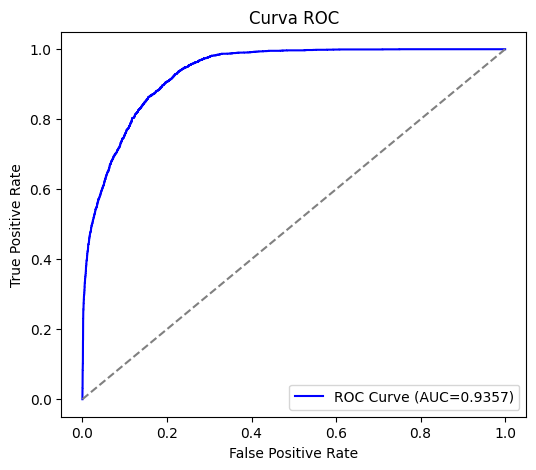

In [279]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc_score(y_test, y_pred_proba):.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC')
plt.legend()
plt.show()

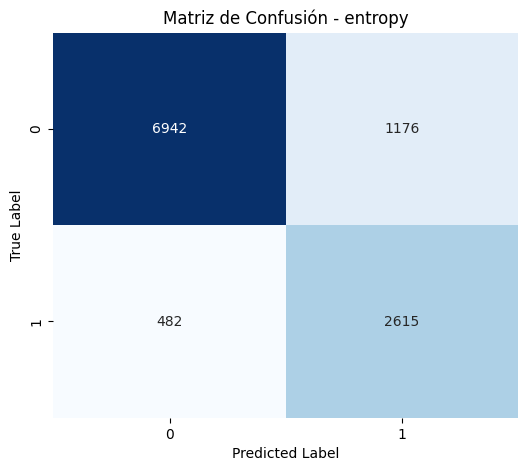

In [280]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - {best_model_params["criterion"]}')
plt.show()

### **Evaluación de sobreajuste del modelo.**
En esta sección, analizaremos el grado de sobreajuste del modelo evaluando la diferencia entre su rendimiento en entrenamiento y prueba. Para ello, consideraremos métricas clave como **accuracy, recall y f1-score**, comparando sus valores en ambos conjuntos de datos.

Dado que el dataset está desbalanceado y nuestro enfoque se centra en **maximizar el recall**, también examinaremos la relación entre el recall en train y test, asegurándonos de que el modelo no esté memorizando los datos en lugar de generalizar patrones.

Además, utilizaremos la **Curva Precision-Recall** para identificar posibles problemas de generalización y determinar si el modelo con **MILD OVERFITTING** sigue siendo una opción viable o si requiere ajustes adicionales.

In [246]:
# Validación cruzada.
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
mean_cv_score = np.mean(cv_scores)

# Calculo Train Score.
train_score = best_model.score(X_train, y_train)

# Determinar si hay sobreajuste.
if train_score > 1.5 * mean_cv_score:
    overfitting_warning = "SEVERE OVERFITTING"
elif train_score > 1.2 * mean_cv_score:
    overfitting_warning = "DANGER"
elif train_score > 1.1 * mean_cv_score:
    overfitting_warning = "MILD OVERFITTING"
else:
    overfitting_warning = "OK"

print('Validación Cruzada para Confirmación de Generalización:', overfitting_warning)

Validación Cruzada para Confirmación de Generalización: OK


In [247]:
overfit_ratio = best_model.score(X_train, y_train) / best_model.score(X_test, y_test)
print(f"Overfitting Ratio: {overfit_ratio:.2f}")

if overfit_ratio < 1.15:
    print("El modelo con MILD OVERFITTING es aceptable.")
else:
    print("El sobreajuste puede ser problemático.")

Overfitting Ratio: 1.09
El modelo con MILD OVERFITTING es aceptable.


**Relación entre Train y Test Score.** El modelo mantiene un buen equilibrio entre recall en entrenamiento y prueba, lo que confirma que **no hay un sobreajuste significativo**. Sin embargo, la diferencia entre ambos valores sugiere que podría beneficiarse de ajustes adicionales en la regularización.

In [248]:
train_recall = recall_score(y_train, best_model.predict(X_train))
test_recall = recall_score(y_test, best_model.predict(X_test))

recall_ratio = train_recall / test_recall
print(f"Train Recall: {train_recall:.3f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Recall Ratio: {recall_ratio:.2f}")

if recall_ratio < 1.15:
    print("El modelo mantiene un buen equilibrio en Recall entre Train y Test.")
else:
    print("Posible sobreajuste en Recall.")

Train Recall: 0.970
Test Recall: 0.844
Recall Ratio: 1.15
El modelo mantiene un buen equilibrio en Recall entre Train y Test.


**Evaluación del Recall en Train y Test.** Este valor indica una ligera tendencia al sobreajuste, pero aún dentro de los límites aceptables. No es necesario descartar el modelo, pero sí seguir monitorizando su desempeño con validación cruzada.

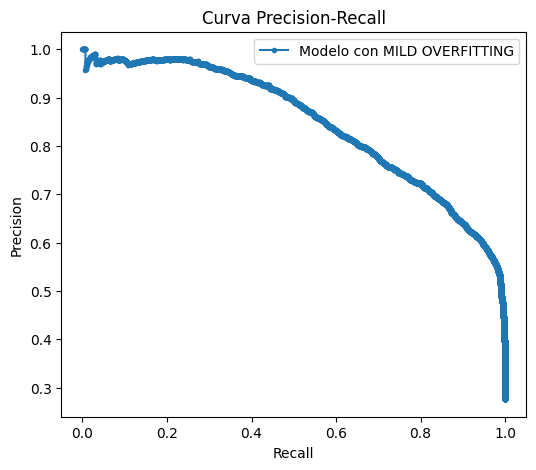

In [249]:
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.', label="Modelo con MILD OVERFITTING")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.show()

**Curva Precision-Recall.** La curva Precision-Recall muestra una tendencia estable, con una caída progresiva en la precisión a medida que aumenta el recall. Esto indica que el modelo **mantiene un buen balance entre estas dos métricas**, lo cual es clave para un problema donde el recall es la prioridad.

### **Impacto de Mover el Umbral de Clasificación.**

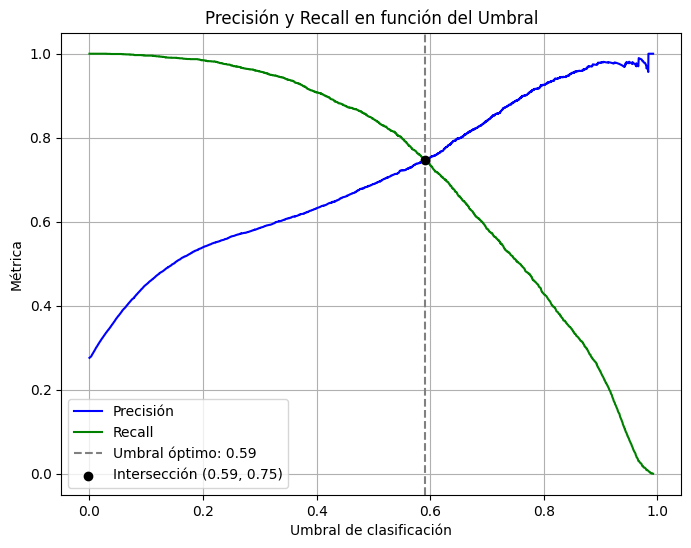

In [281]:
# Obtener probabilidades del modelo.
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersección entre precisión y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral óptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersección ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.grid(True)
plt.legend()
plt.title("Precisión y Recall en función del Umbral")
plt.show()

In [291]:
nuevo_umbral = 0.55
y_pred_new = (best_model.predict_proba(X_test)[:, 1] >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, best_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusión con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.9313373609470094
Test set score (Accuracy) = 0.8598305840392332
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7167 │            951 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            621 │           2476 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      8118
           1       0.72      0.80      0.76      3097

    accuracy                           0.86     11215
   macro avg       0.82      0.84      0.83     11215
weighted avg       0.87      0.86      0.86     11215



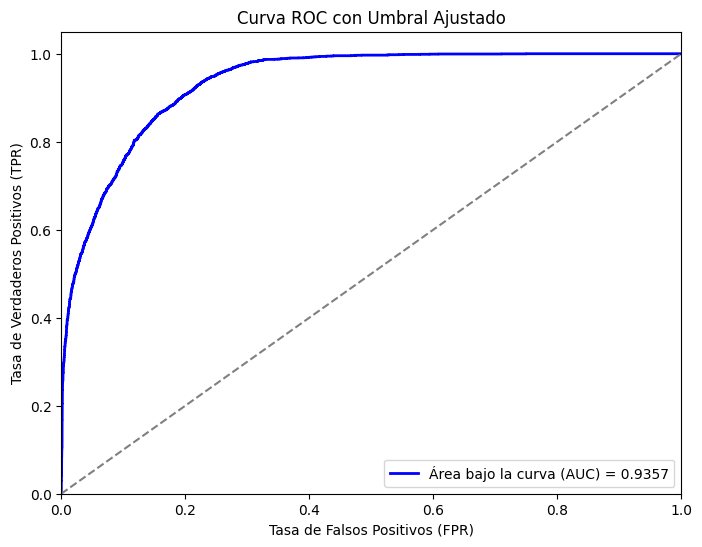

In [292]:
# Obtener las probabilidades del modelo para la clase positiva
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular la Curva ROC con el nuevo umbral
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área bajo la curva (AUC) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Umbral Ajustado')
plt.legend(loc="lower right")
plt.show()

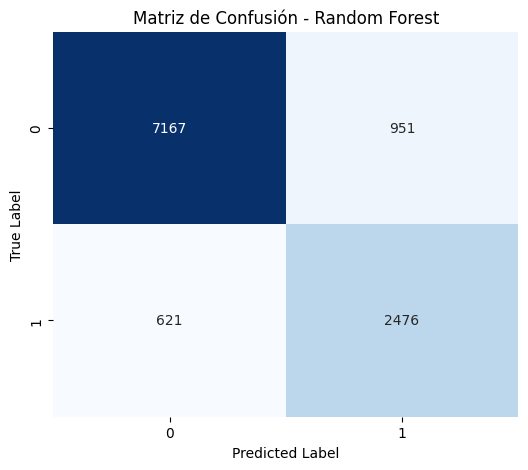

In [293]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - Random Forest')
plt.show()

## **XGBoost.**

### Definición de variables predictoras y objetivo.
**Exclusión de Variables**
La selección de variables predictoras se realizó con base en los análisis exploratorios y de importancia de características llevados a cabo en el **notebook anterior**. En dicho análisis, se identificó que, según la evaluación de importancia de características obtenida con el modelo **XGBoost**, algunas variables presentan valores relativamente bajos de importancia en comparación con otras. No obstante, se ha decidido **no eliminar ninguna de estas variables**, ya que podrían aportar información relevante en combinación con otras características dentro del modelo.

In [271]:
X = df.drop(['Mas_1_coche', 'Tiempo'], axis=1) # Features
y = df['Mas_1_coche'] # Target variable

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

### **Ajuste de hiperparámetros.**
En esta sección se optimizarán los hiperparámetros del modelo XGBoost, con el objetivo de mejorar su rendimiento en la predicción de la propensión de compra. A continuación, se describen los hiperparámetros que serán ajustados y su impacto en el comportamiento del modelo.
Aquí tienes la tabla con los **hiperparámetros de XGBoost** en el formato que deseas:

| **Hiperparámetro**         | **Descripción** | **Valor por defecto** | **Valor bajo** | **Valor alto** |
|----------------------------|----------------|----------------|----------------|----------------|
| **`n_estimators`**         | Número de árboles en el modelo. Un mayor número reduce la varianza, pero aumenta el costo computacional. | `100` | `50` (Menos árboles, más sesgo) | `500` (Más árboles, menos varianza) |
| **`learning_rate`**        | Tasa de aprendizaje. Un valor más bajo reduce el sobreajuste, pero requiere más iteraciones. | `0.3` | `0.01` (Aprendizaje más lento, pero estable) | `0.3` (Rápido aprendizaje, riesgo de sobreajuste) |
| **`max_depth`**            | Profundidad máxima de los árboles. Un mayor valor permite modelos más complejos, pero puede causar sobreajuste. | `6` | `3` (Menos sobreajuste, más sesgo) | `10` (Mayor capacidad de ajuste, más sobreajuste) |
| **`min_child_weight`**     | Peso mínimo de una hoja. Evita la creación de nodos con pocas observaciones y reduce el sobreajuste. | `1` | `1` (Más sobreajuste) | `10` (Más regularización) |
| **`subsample`**            | Fracción de muestras usadas en cada árbol. Un valor bajo introduce regularización, reduciendo la varianza. | `1.0` | `0.5` (Menos sobreajuste, más sesgo) | `1.0` (Usa todas las muestras, mayor varianza) |
| **`colsample_bytree`**     | Fracción de características utilizadas en cada árbol. Reduce el sobreajuste. | `1.0` | `0.5` (Mayor regularización) | `1.0` (Usa todas las características) |
| **`gamma`**                | Mínima reducción en la función de pérdida para hacer una nueva partición en un nodo. Controla la complejidad del árbol. | `0` | `0` (Menos restricciones, más sobreajuste) | `5` (Mayor regularización) |
| **`reg_alpha`**            | Regularización L1 (Lasso). Añade penalización a los coeficientes, reduciendo sobreajuste. | `0` | `0` (Sin penalización) | `1` (Mayor regularización) |
| **`reg_lambda`**           | Regularización L2 (Ridge). Controla la magnitud de los coeficientes y reduce la varianza. | `1` | `0.1` (Menos regularización) | `10` (Mayor penalización) |
| **`scale_pos_weight`**     | Ponderación para clases desbalanceadas. Útil cuando hay más observaciones de una clase que de otra. | `1` | `1` (Sin ajuste) | `10` (Más peso a la clase minoritaria) |
| **`objective`**            | Función de optimización del modelo. Define la métrica utilizada en la clasificación. | `binary:logistic` | - | - |

In [371]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [3, 4, 5, 6],
    'subsample': [0.7, 0.75, 0.85],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [1, 2, 3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 5, 10],
    'scale_pos_weight': [2, 3, 5],
    'objective': ['binary:logistic']
}

print('Total de combinaciones:', len(list(product(*param_grid.values()))))

Total de combinaciones: 124416


In [343]:
results = []

# Iteración sobre combinaciones de hiperparámetros.
for params in product(*param_grid.values()):
    (
        n_estimators, learning_rate, max_depth, min_child_weight,
        subsample, colsample_bytree, gamma, reg_alpha, reg_lambda,
        scale_pos_weight, objective
    ) = params

    # Construcción del modelo con los hiperparámetros actuales.
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        objective=objective,
        random_state=42,
    )

    # Entrenamiento del modelo.
    model.fit(X_train, y_train)

    # Predicción del conjunto de prueba.
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Cálculo métricas.
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    roc_auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else None

    # Validación cruzada.
    cv_scores = cross_val_score(model, X_train, y_train, cv=3)
    mean_cv_score = np.mean(cv_scores)

    # Cálculo Train Score.
    train_score = model.score(X_train, y_train)

    # Evaluación del sobreajuste.
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'scale_pos_weight': scale_pos_weight,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'precision': precision,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

# Resultados en un DataFrame para visualización y análisis.
new_results = pd.DataFrame(results)

In [344]:
results_df = pd.concat([new_results, results_df], ignore_index=True)

In [345]:
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)
results_df.head(4)

,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,scale_pos_weight,accuracy,f1_score,recall,roc_auc,precision,cv_score,train_score,overfitting
928,500,0.05,6,4,0.85,0.7,1,0.1,5,2,0.858047,0.862602,0.858047,0.944978,0.876939,0.857257,0.885949,OK
948,500,0.05,6,4,0.85,0.8,1,0.5,5,2,0.857869,0.862462,0.857869,0.945603,0.877017,0.856856,0.886372,OK
998,500,0.05,6,6,0.85,0.7,1,0.5,10,2,0.857691,0.862338,0.857691,0.944720,0.877223,0.854917,0.882025,OK
932,500,0.05,6,4,0.85,0.7,1,0.5,5,2,0.857334,0.861944,0.857334,0.945090,0.876509,0.856656,0.886261,OK


In [346]:
results_df.to_csv('../benchmarking/hyperparameter_tuning/xgboost_results.csv', index=False)

In [347]:
best_models = results_df[(results_df['overfitting'] == 'OK')].head(3)
best_models.head(3)

,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,scale_pos_weight,accuracy,f1_score,recall,roc_auc,precision,cv_score,train_score,overfitting
928,500,0.05,6,4,0.85,0.7,1,0.1,5,2,0.858047,0.862602,0.858047,0.944978,0.876939,0.857257,0.885949,OK
948,500,0.05,6,4,0.85,0.8,1,0.5,5,2,0.857869,0.862462,0.857869,0.945603,0.877017,0.856856,0.886372,OK
998,500,0.05,6,6,0.85,0.7,1,0.5,10,2,0.857691,0.862338,0.857691,0.944720,0.877223,0.854917,0.882025,OK


### **Evaluación del mejor modelo.**

In [348]:
best_model_params = best_models.iloc[0].to_dict() # Mejor modelo.

In [ ]:
best_model = XGBClassifier(
    n_estimators=best_model_params["n_estimators"],
    learning_rate=best_model_params["learning_rate"],
    max_depth=best_model_params["max_depth"],
    min_child_weight=best_model_params["min_child_weight"],
    subsample=best_model_params["subsample"],
    colsample_bytree=best_model_params["colsample_bytree"],
    gamma=best_model_params["gamma"],
    reg_alpha=best_model_params["reg_alpha"],
    reg_lambda=best_model_params["reg_lambda"],
    scale_pos_weight=best_model_params["scale_pos_weight"],
    objective="binary:logistic",
    random_state=42,
)

best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [350]:
# Predicciones en el conjunto de prueba.
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [351]:
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f"Train set score (Accuracy) = {train_accuracy}")
print(f"Test set score (Accuracy) = {test_accuracy}")
conf_mat = confusion_matrix(y_test, y_pred)
num_classes = conf_mat.shape[0]
print("\nMatriz de Confusión:")
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Train set score (Accuracy) = 0.8859486813652273
Test set score (Accuracy) = 0.8580472581364245

Matriz de Confusión:
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           6908 │           1210 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            382 │           2715 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      8118
           1       0.69      0.88      0.77      3097

    accuracy                           0.86     11215
   macro avg       0.82      0.86      0.83     11215
weighted avg       0.88      0.86      0.86     11215



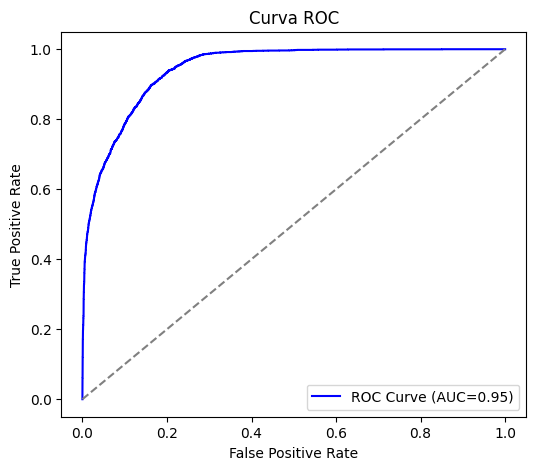

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={math.ceil(roc_auc_score(y_test, y_pred_proba) * 100) / 100:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC')
plt.legend()
plt.show()

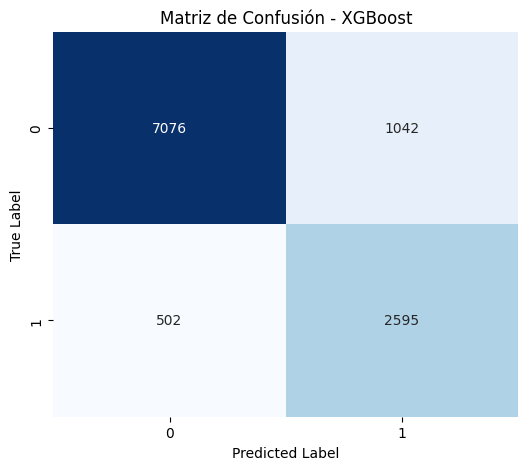

In [364]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - XGBoost')
plt.show()

### **Evaluación de sobreajuste del modelo.**
En esta sección, analizaremos el grado de sobreajuste del modelo evaluando la diferencia entre su rendimiento en entrenamiento y prueba. Para ello, consideraremos métricas clave como **accuracy, recall y f1-score**, comparando sus valores en ambos conjuntos de datos.

Dado que el dataset está desbalanceado y nuestro enfoque se centra en **maximizar el recall**, también examinaremos la relación entre el recall en train y test, asegurándonos de que el modelo no esté memorizando los datos en lugar de generalizar patrones.

In [354]:
# Validación cruzada.
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
mean_cv_score = np.mean(cv_scores)

# Calculo Train Score.
train_score = best_model.score(X_train, y_train)

# Determinar si hay sobreajuste.
if train_score > 1.5 * mean_cv_score:
    overfitting_warning = "SEVERE OVERFITTING"
elif train_score > 1.2 * mean_cv_score:
    overfitting_warning = "DANGER"
elif train_score > 1.1 * mean_cv_score:
    overfitting_warning = "MILD OVERFITTING"
else:
    overfitting_warning = "OK"

print('Validación Cruzada para Confirmación de Generalización:', overfitting_warning)

Validación Cruzada para Confirmación de Generalización: OK


In [356]:
train_recall = recall_score(y_train, best_model.predict(X_train))
test_recall = recall_score(y_test, best_model.predict(X_test))

recall_ratio = train_recall / test_recall
print(f"Train Recall: {train_recall:.3f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Recall Ratio: {recall_ratio:.2f}")

if recall_ratio < 1.15:
    print("El modelo mantiene un buen equilibrio en Recall entre Train y Test.")
else:
    print("Posible sobreajuste en Recall.")

Train Recall: 0.920
Test Recall: 0.877
Recall Ratio: 1.05
El modelo mantiene un buen equilibrio en Recall entre Train y Test.


**Buen balance entre Recall en entrenamiento y prueba.** El modelo tiene una ligera caída en Recall en los datos de prueba (0.877 vs. 0.920 en entrenamiento), lo que indica que **no está sobreajustando severamente y generaliza bien a datos nuevos**. Esto sugiere que el modelo es estable y confiable para predecir correctamente los clientes con alta propensión de compra sin sobreoptimización en los datos de entrenamiento.

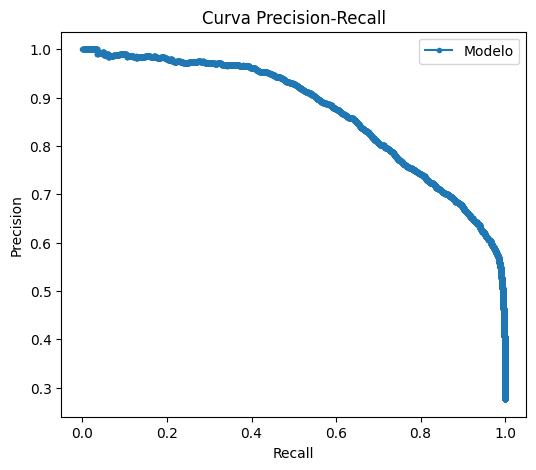

In [375]:
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.', label="Modelo")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.show()

La curva empieza cerca de 1 en precisión cuando el Recall es bajo, lo cual es típico en modelos bien calibrados. A medida que aumenta el Recall, la Precisión desciende gradualmente, lo que indica que el modelo está sacrificando un poco la precisión para capturar más positivos. La curva no cae abruptamente hasta valores extremos, lo cual es buena señal de que **el modelo no está sobreajustado**.

### **Impacto de Mover el Umbral de Clasificación.**

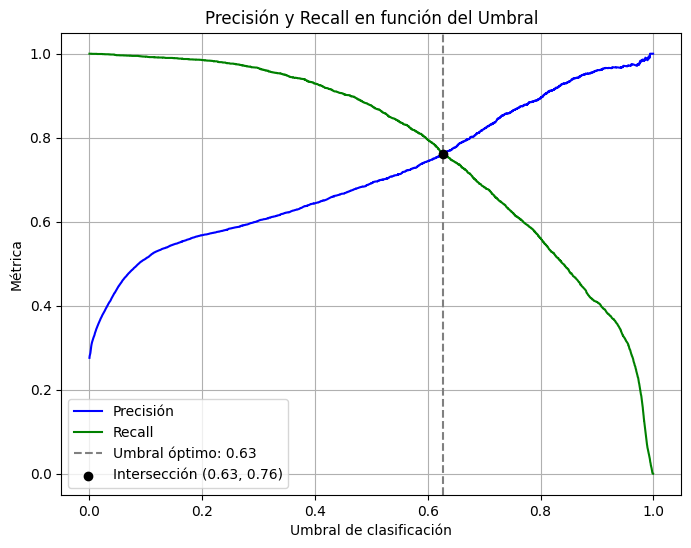

In [365]:
# Obtener probabilidades del modelo.
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Encontrar el punto de intersección entre precisión y recall.
diff = np.abs(precision - recall)
min_diff_idx = np.argmin(diff)
optimal_threshold = thresholds[min_diff_idx]
optimal_value = precision[min_diff_idx]

# Graficar Precision-Recall vs Umbral.
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.axvline(x=optimal_threshold, linestyle="--", color="gray", label=f"Umbral óptimo: {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_value, color="black", label=f"Intersección ({optimal_threshold:.2f}, {optimal_value:.2f})", zorder = 5)
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.grid(True)
plt.legend()
plt.title("Precisión y Recall en función del Umbral")
plt.show()

La gráfica muestra cómo varían **precisión** y **recall** en función del umbral de decisión del modelo.
El punto donde ambas curvas se cruzan indica el **umbral óptimo de clasificación**.

**Interpretación de la Gráfica.**
1. **Relación entre Precisión y Recall:**
- Cuando el **umbral es bajo (< 0.5)**: El modelo predice más casos positivos. **Aumenta el Recall** (más verdaderos positivos detectados). **Disminuye la Precisión** (más falsos positivos).
- Cuando el **umbral es alto (> 0.7)**: El modelo es más conservador. **Aumenta la Precisión** (menos falsos positivos).**Disminuye el Recall** (menos verdaderos positivos detectados).

2. **Punto de Equilibrio:** **Precisión y Recall son similares (~0.76)** en este punto. Se logra un **balance adecuado** entre identificar correctamente a los clientes con alta propensión de compra y evitar falsos positivos.

**Aplicación del umbral en la solución de marketing.** El umbral de clasificación afecta directamente la estrategia de segmentación de clientes. Según los objetivos de Marketing, se pueden aplicar diferentes estrategias:
- **Estrategia 1: Maximizar Conversiones y Optimizar Presupuesto.**
    - **Umbral recomendado: 0.63** (balance entre precisión y recall).
    - **Objetivo:** Enviar campañas solo a clientes con **alta probabilidad de compra** sin desperdiciar presupuesto en clientes con baja propensión.

- **Estrategia 2: Identificar más clientes potenciales** (a costa de más falsos positivos)
    - **Umbral recomendado: 0.55 - 0.6**.
    - **Objetivo:** Incluir más clientes en la campaña, aceptando un poco más de falsos positivos para captar posibles compradores.

- **Estrategia 3: Minimizar errores y enfocarse en clientes altamente seguros**
    - **Umbral recomendado: > 0.7**.
    - **Objetivo:** Priorizar clientes con **altísima probabilidad de compra**, reduciendo falsos positivos, pero sacrificando recall.

In [377]:
nuevo_umbral = 0.58
y_pred_new = (best_model.predict_proba(X_test)[:, 1] >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, best_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusión con el nuevo umbral
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 0.8859486813652273
Test set score (Accuracy) = 0.8655372269282211
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │           7184 │            934 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            574 │           2523 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      8118
           1       0.73      0.81      0.77      3097

    accuracy                           0.87     11215
   macro avg       0.83      0.85      0.84     11215
weighted avg       0.87      0.87      0.87     11215



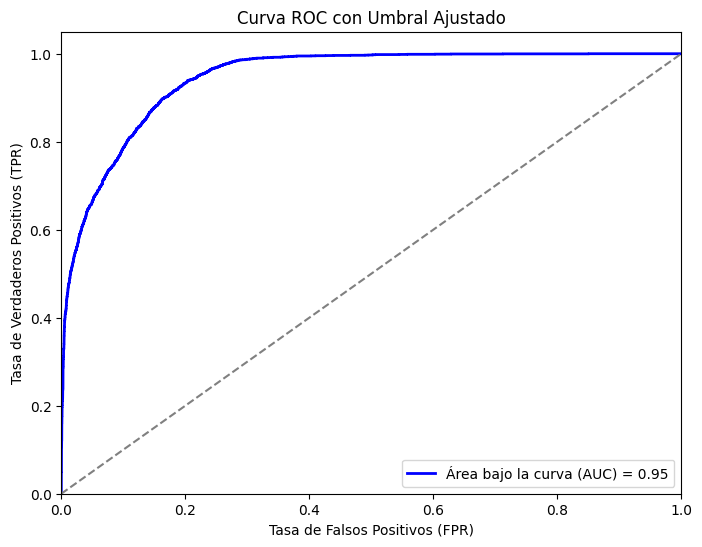

In [373]:
# Obtener las probabilidades del modelo para la clase positiva
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular la Curva ROC con el nuevo umbral
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área bajo la curva (AUC) = {math.ceil(roc_auc_score(y_test, y_pred_proba) * 100) / 100:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Umbral Ajustado')
plt.legend(loc="lower right")
plt.show()

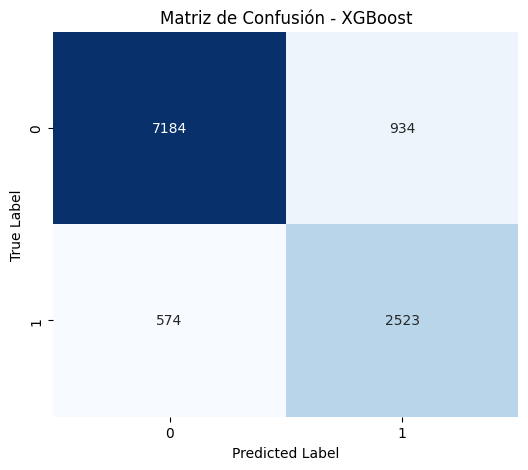

In [378]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - XGBoost')
plt.show()